In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sko.GA import GA

In [2]:
df = pd.read_csv("Snowy_I-695_Sample01.csv")
df = df.dropna()

In [3]:
df['speed'] = df ['Speed [km/h]'] * 0.2778
df['y [m]'] = df['y [m]']-df['y [m]'].min()
df['x [m]'] = pd.to_numeric(df['x [m]'], errors='coerce')
df['x [m]'] = df['x [m]']-df['x [m]'].min()
df['distance'] = np.sqrt(df['x [m]']**2 + df['y [m]']**2)
df['distance'] = df['distance'] + 2.5
df['Rear_Bumper'] = df['distance'] - 2.5
df['Front_Bumper'] = df['distance'] + 2.5

In [4]:
def find_leading_vehicle_and_gap_speed_vectorized(group):
    vehicle_ids = group['Vehicle ID'].values
    rear_bumpers = group['Rear_Bumper'].values
    front_bumpers = group['Front_Bumper'].values
    speeds = group['speed'].values

    n = len(vehicle_ids)

    if n > 1:
        gap_matrix = np.full((n, n), np.inf)

        for i in range(n):
            valid_indices = (rear_bumpers - front_bumpers[i]) > 0
            gap_matrix[i, valid_indices] = rear_bumpers[valid_indices] - front_bumpers[i]

        np.fill_diagonal(gap_matrix, np.inf)

        min_gaps = np.min(gap_matrix, axis=1)
        min_gap_indices = np.argmin(gap_matrix, axis=1)

        leading_vehicle_ids = np.empty(n, dtype=object)
        leading_vehicle_ids[min_gaps != np.inf] = vehicle_ids[min_gap_indices][min_gaps != np.inf]
        leading_vehicle_ids[min_gaps == np.inf] = None

        leading_vehicle_speeds = np.empty(n, dtype=object)
        leading_vehicle_speeds[min_gaps != np.inf] = speeds[min_gap_indices][min_gaps != np.inf]
        leading_vehicle_speeds[min_gaps == np.inf] = None
    else:
        leading_vehicle_ids = np.array([None])
        leading_vehicle_speeds = np.array([None])
        min_gaps = np.array([np.inf])

    group['leading_vehicle'] = leading_vehicle_ids
    group['gap'] = min_gaps
    group['leading_vehicle_speed'] = leading_vehicle_speeds
    return group

# Group the data by time and find car following pairs within each time step
df1 = df.groupby('Time [s]', group_keys=False).apply(find_leading_vehicle_and_gap_speed_vectorized)

In [5]:
df1 = df1.iloc[2::6]

In [6]:
veh = df1[df1['Vehicle ID'].isin([104])]

In [7]:
veh.loc[:, 'leading_vehicle_location'] = veh.loc[:, 'distance'] + veh.loc[:, 'gap']
veh.loc[:, 'leading_vehicle_speed'] =veh.loc[:, 'leading_vehicle_speed'].clip(lower=0)

C:\Users\kaitai74\AppData\Local\Temp\ipykernel_7992\2339798250.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  veh.loc[:, 'leading_vehicle_location'] = veh.loc[:, 'distance'] + veh.loc[:, 'gap']
C:\Users\kaitai74\AppData\Local\Temp\ipykernel_7992\2339798250.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  veh.loc[:, 'leading_vehicle_speed'] =veh.loc[:, 'leading_vehicle_speed'].clip(lower=0)


In [8]:
df1['Vehicle ID'].unique()

array([  1,  15,  16,  23,  24,  28,  30,  32,  38,  44,  52,  58,  66,
        72,  77,  84,  88,  97, 104, 110, 112, 122, 128, 132, 133, 138,
       145, 152, 155, 160, 169, 175, 183, 191, 199, 203, 213, 220, 229,
       234, 239, 250, 258, 264, 268, 273, 281, 285, 296, 307, 315, 327,
       333, 338, 342, 345, 355, 361, 368, 378, 387, 395, 399, 416, 423,
       432, 443, 447, 453, 460, 470, 481, 491, 497, 504, 512, 519, 542,
       551, 560, 567, 571, 581, 588, 593, 596, 600, 603, 606, 613, 620,
       624, 628, 639, 649, 657, 663, 671, 680, 686, 693, 702, 709, 715,
       721, 730, 735, 744, 748, 758, 769, 779, 787], dtype=int64)

In [9]:
# Define the IDM model function
def idm(xLead, vLead, xFoll, vFoll, model_params):
    s0 = model_params['s0']
    T = model_params['T']
    a = model_params['a']
    b = model_params['b']
    delta = 4  
    v0 = model_params['v0']
    
    s_star = s0 + max(0, vFoll * T + vFoll * (vFoll - vLead) / (2 * np.sqrt(a * b)))
    gap = max(xLead - xFoll, 0.1)  # or some small positive number
    return a * (1 - (vFoll / v0)**delta - (s_star / gap)**2)

# Function to run the simulation using your position update formula
def idmrun_simulation(model_params, xLead, vLead, xFollInitial, vFollInitial, dt, num_steps):
    xFoll = [xFollInitial]
    vFoll = [vFollInitial]

    for t in range(1, num_steps):
        acc = idm(xLead.iloc[t], vLead.iloc[t], xFoll[t-1], vFoll[t-1], model_params)
        new_vFoll = vFoll[t-1] + acc * dt
        new_xFoll = xFoll[t-1] + (vFoll[t-1] + new_vFoll) * dt / 2
        vFoll.append(new_vFoll)
        xFoll.append(new_xFoll)

    return xFoll, vFoll

# Function to calculate RMSE of following distance
def idmcalculate_rmse_d(model_params, xLead, vLead, xFollInitial, vFollInitial, dt, num_steps, xReal):
    xSim, _ = idmrun_simulation(model_params, xLead, vLead, xFollInitial, vFollInitial, dt, num_steps)
    errors = np.array(xReal) - np.array(xSim)
    return np.sqrt(np.mean(errors**2))

# GA optimization setup
# Define real-world or target data for lead and following vehicles
xLead_real = veh.loc[:, 'leading_vehicle_location'] # Position data of lead vehicle
vLead_real = veh.loc[:, 'leading_vehicle_speed'] # Velocity data of lead vehicle
xFoll_real = veh.loc[:, 'distance'] # Position data of following vehicle (real)

# Initial conditions
xFollInitial = xFoll_real.iloc[0]
vFollInitial = veh.loc[:, 'speed'].iloc[0] # Assuming the following vehicle starts from rest

# Simulation parameters
dt = 0.2 # Time step, updated to 0.2 seconds
num_steps = len(xLead_real)

# Define the bounds for IDM parameters (excluding delta)
IDM_param_bounds = {'s0': (1, 5), 'T': (0.1, 3), 'a': (0.1, 4), 'b': (0.1, 9), 'v0': (8, 33)}

# Define the fitness function for GA
def fitness_idm(model_params):
    params = {'s0': model_params[0], 'T': model_params[1], 'a': model_params[2], 'b': model_params[3], 'v0': model_params[4]}
    return idmcalculate_rmse_d(params, xLead_real, vLead_real, xFollInitial, vFollInitial, dt, num_steps, xFoll_real)
# Initialize and run the GA for IDM 
idmga = GA(func=fitness_idm, 
           n_dim=5, 
           size_pop=100, 
           max_iter=200, 
           prob_mut=0.05,  # Mutation probability
           lb=[IDM_param_bounds[key][0] for key in IDM_param_bounds], 
           ub=[IDM_param_bounds[key][1] for key in IDM_param_bounds], ) 

idmbest_params, idmbest_rmse = idmga.run()


In [10]:
idmoptimized_params = {key: idmbest_params[i] for i, key in enumerate(IDM_param_bounds)}
print("IDM Optimized Parameters:", idmoptimized_params)
print("IDM Best RMSE:", idmbest_rmse)


IDM Optimized Parameters: {'s0': 2.8477853811947313, 'T': 0.5875359918932912, 'a': 0.8629144096808793, 'b': 1.5666746166845755, 'v0': 31.415091255363414}
IDM Best RMSE: [0.23786173]


In [11]:
def calculate_speed_acceleration(vFoll):
    aFoll = np.diff(vFoll) / dt
    aFoll = np.append(aFoll, aFoll[-1])  # Append the last value to match the length
    return vFoll, aFoll
def calculate_gap(xFoll, xLead):
    return xLead - xFoll
# Assuming the real data variables are already defined
aFoll_real = veh['Tan. Acc. [ms-2]']
vFoll_real = veh['speed']
xLead_real = veh['leading_vehicle_location']
xFoll_real = veh['distance']
gap_real = veh['gap']
# Function to run the simulation for a specific model
def run_model_simulation(model_func, model_params, xLead, vLead, xFollInitial, vFollInitial, dt, num_steps):
    xFoll = [xFollInitial]
    vFoll = [vFollInitial]

    for t in range(1, num_steps):
        acc = model_func(xLead.iloc[t], vLead.iloc[t], xFoll[t-1], vFoll[t-1], model_params)
        new_vFoll =max(0, vFoll[t-1] + acc * dt)
        new_xFoll = xFoll[t-1] + (vFoll[t-1] + new_vFoll) * dt / 2
        vFoll.append(new_vFoll)
        xFoll.append(new_xFoll)

    return xFoll, vFoll

# Run simulations for IDM 
xFollSim_idm, vFollSim_idm = run_model_simulation(idm, idmoptimized_params, xLead_real, vLead_real, xFollInitial, vFollInitial, dt, num_steps)
# Calculate acceleration and gap for IDM and CIDM
_, aFollSim_idm = calculate_speed_acceleration(vFollSim_idm)
gap_sim_idm = calculate_gap(np.array(xFollSim_idm), np.array(xLead_real))

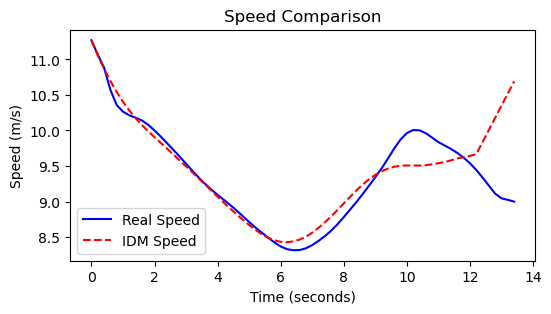

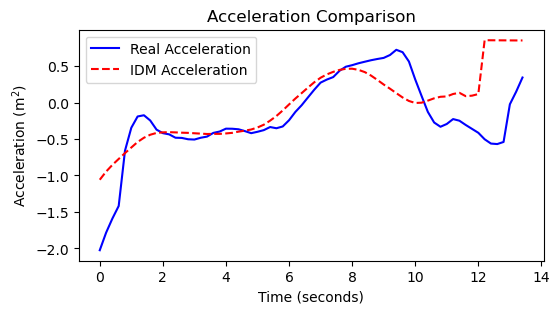

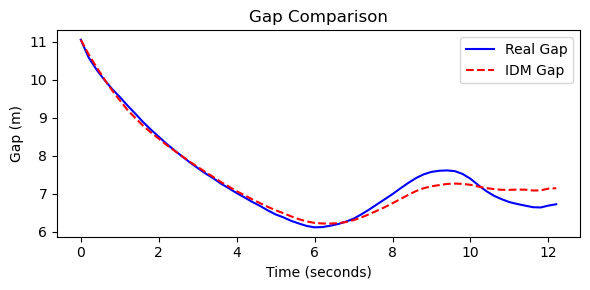

In [12]:
# Define time array for plotting
time_array = np.arange(0, num_steps * dt, dt)

# Truncate arrays to the length of the shortest one for plotting
min_length = min(len(time_array), len(vFoll_real), len(vFollSim_idm))
time_array = time_array[:min_length]
vFoll_real = vFoll_real[:min_length]
vFollSim_idm = vFollSim_idm[:min_length]
aFoll_real = aFoll_real[:min_length]
aFollSim_idm = aFollSim_idm[:min_length]
gap_real = gap_real[:min_length]
gap_sim_idm = gap_sim_idm[:min_length]




# Plot Speed
plt.figure(figsize=(6, 3))
plt.plot(time_array, vFoll_real, label='Real Speed', color='blue')
plt.plot(time_array, vFollSim_idm, label='IDM Speed', color='red', linestyle='dashed')
plt.xlabel('Time (seconds)')
plt.ylabel('Speed (m/s)')
plt.title('Speed Comparison')
plt.legend()

# Plot Acceleration
plt.figure(figsize=(6, 3))
plt.plot(time_array, aFoll_real, label='Real Acceleration', color='blue')
plt.plot(time_array, aFollSim_idm, label='IDM Acceleration', color='red', linestyle='dashed')
plt.xlabel('Time (seconds)')
plt.ylabel('Acceleration (m$^2$)')
plt.title('Acceleration Comparison')
plt.legend()

# Plot Gap
plt.figure(figsize=(6, 3))
plt.plot(time_array, gap_real, label='Real Gap', color='blue')
plt.plot(time_array, gap_sim_idm, label='IDM Gap', color='red', linestyle='dashed')

plt.xlabel('Time (seconds)')
plt.ylabel('Gap (m)')
plt.title('Gap Comparison')
plt.legend()

plt.tight_layout()
plt.show()